# Gaussian elimination to expose leaves

**Idea**: $b$-reduction as a method of exposing leaves has 2 limitations:
* Arbitrariness on the choice of $b$
* No control on how the compression rate changes

**Proposal**: 
* Build a graph with no leaves
* Instead of removing factors, do Gaussian elimination on the parity-check matrix which defines the graph
* Build a new graph from the matrix resulting after Gaussian elimination

The new graph will have some leaves (here we compute how many) while the space of solutions, hence the rate, is left untouched.

In [1]:
using Printf, Plots, ProgressMeter
include("../code/headers.jl")
include("../code/SimulationNEW.jl")

## How many leaves does Gaussian elimination expose?

At fixed rate $R=0.3$, let $n$ increase

In [2]:
const q = 2
nvals = Int.(floor.(10 .^(LinRange(1,3.1,7))))
R = 0.3
mvals = ceil.(Int, nvals.*(1-R))
niter = 50
randseed = 1234
variable_degrees = [[Dict{Int64,Float64}() for it in 1:niter] for n in 1:length(nvals)]
nleaves = [zeros(Int, niter) for n in 1:length(nvals)];

For each value of $n$, sample 50 random graphs and store the degree profiles to make some statistics

In [3]:
for (i,n) in enumerate(nvals)
    println("n=$n. $i of $(length(nvals))")
    @showprogress for it in 1:niter
        lm = LossyModel(q, n, mvals[i], randseed=randseed+niter*i+it)
        gfref!(lm)
        nleaves[i][it] = nvarleaves(lm.fg)
        variable_degrees[i][it] = vardegrees_distr(lm.fg)
    end
end

n=10. 1 of 7


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


n=22. 2 of 7
n=50. 3 of 7
n=112. 4 of 7


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


n=251. 5 of 7


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


n=562. 6 of 7


Progress: 100%|█████████████████████████████████████████| Time: 0:00:51


n=1258. 7 of 7


Progress: 100%|█████████████████████████████████████████| Time: 0:18:15


Plot the average number of leaves as $n$ increases

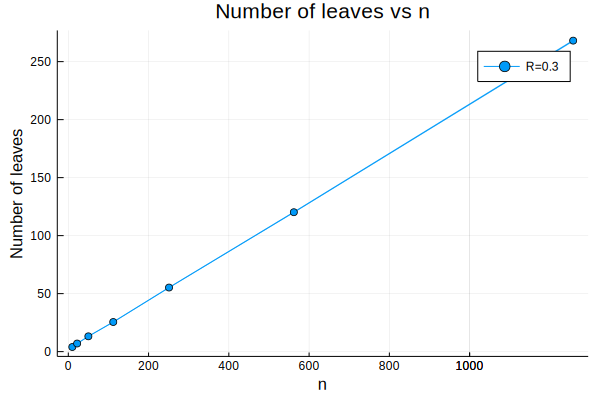

In [4]:
avg_leaves = [mean(nleaves[j]) for j in eachindex(nvals)]
sd_leaves = [std(nleaves[j])/sqrt(niter) for j in eachindex(nvals)]
plt = Plots.plot(nvals, avg_leaves, markershape=:circle, label="R=$R", ribbon=sd_leaves)
xlabel!("n")
ylabel!("Number of leaves")
title!("Number of leaves vs n")

In [5]:
slope = nvals\avg_leaves
@printf("Slope: %.2f\n", slope)

Slope: 0.21


## Estimate the proportionality constant between number of leaves and n as R varies

Repeat the procedure at the beginning of this notebook, for different rates.
For each rate, fit the slope from the $n$ vs $N_{leaves}$ plot

In [6]:
nvals = Int.(floor.(10 .^(LinRange(1,2.7,7))))
Rvals = 0.1:0.05:0.7
mvals = ceil.(Int, nvals.*(1-R))
niter = 50
randseed = 1234
nleaves_new = [[zeros(Int, niter) for n in 1:length(nvals)] for R in Rvals];

In [7]:
for (r,R) in enumerate(Rvals)
    println("### R=$R. $r of $(length(Rvals))")
    mvals = ceil.(Int, nvals.*(1-R))
    @showprogress for (i,n) in enumerate(nvals)
        for it in 1:niter
            lm = LossyModel(q, n, mvals[i], randseed=randseed+niter*i+it)
            gfref!(lm)
            nleaves_new[r][i][it] = nvarleaves(lm.fg)
            variable_degrees[i][it] = vardegrees_distr(lm.fg)
        end
    end
end

### R=0.1. 1 of 13


Progress: 100%|█████████████████████████████████████████| Time: 0:01:40


### R=0.15. 2 of 13


Progress: 100%|█████████████████████████████████████████| Time: 0:01:18


### R=0.2. 3 of 13


Progress: 100%|█████████████████████████████████████████| Time: 0:01:00


### R=0.25. 4 of 13


Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


### R=0.3. 5 of 13


Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


### R=0.35. 6 of 13


Progress: 100%|█████████████████████████████████████████| Time: 0:00:29


### R=0.4. 7 of 13


Progress: 100%|█████████████████████████████████████████| Time: 0:00:23


### R=0.45. 8 of 13


Progress: 100%|█████████████████████████████████████████| Time: 0:00:17


### R=0.5. 9 of 13


Progress: 100%|█████████████████████████████████████████| Time: 0:00:13


### R=0.55. 10 of 13


Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


### R=0.6. 11 of 13


Progress: 100%|█████████████████████████████████████████| Time: 0:00:07


### R=0.65. 12 of 13


Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


### R=0.7. 13 of 13


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


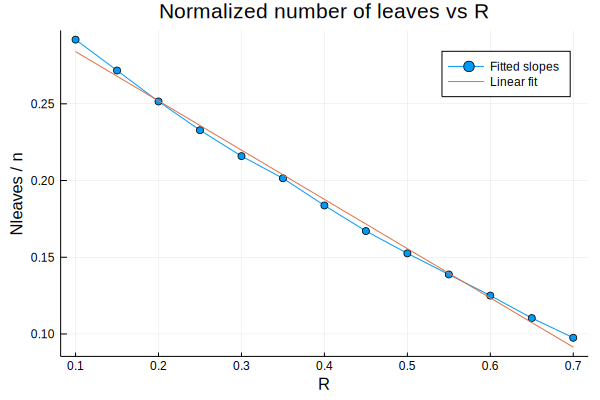

In [8]:
avg_leaves_new = [[mean(nleaves_new[r][j]) for j in eachindex(nvals)] for r in eachindex(Rvals)]
slopes = [nvals\avg_leaves_new[r] for r in eachindex(Rvals)]

plt = Plots.plot(Rvals, slopes, markershape=:circle, label="Fitted slopes")
xlabel!("R")
ylabel!("Nleaves / n")
title!("Normalized number of leaves vs R")

X = [Rvals ones(length(Rvals))]
Y = slopes
z = X\Y
Plots.plot!(plt, collect(0.1:0.01:0.7), z[1] .* collect(0.1:0.01:0.7) .+ z[2], label="Linear fit")

## Compare with b-reduction in terms of compression performance

Run Max-Sum on graphs with $b$-reduction first and then with Gaussian elimination. Same size, same compression rate

In [9]:
n = 2000
mvals = reverse(Int.(round.(n*(0.2:0.15:0.95))))
niter = 150
sims_b = Vector{Simulation{MS}}(undef, length(mvals))
sims_gauss = Vector{Simulation{MS}}(undef, length(mvals))
ms = MS(maxiter=100, gamma=5e-3);

In [13]:
for (j,m) in enumerate(mvals)
    println("##### R = ", round(1-m/n, digits=2), ". ",
        "$j of $(length(mvals)) #####")
    b = 100
    sims_b[j] = Simulation(q, n, m, ms, b=b, niter=niter, randseed=randseed+200*j, 
        verbose=true, showprogress=false)
    sims_gauss[j] = Simulation(q, n, m, ms, b=0, niter=niter, gauss_elim=true,
        randseed=randseed+200*j, verbose=true, showprogress=false)
end

##### R = 0.05. 1 of 6 #####
# Finished iter 1 of 150: U after 100 iters, 5 trials. Parity 6. Distortion 0.50.
# Finished iter 2 of 150: U after 100 iters, 5 trials. Parity 2. Distortion 0.50.
# Finished iter 3 of 150: C after 100 iters, 2 trials. Parity 0. Distortion 0.41.
# Finished iter 4 of 150: C after 97 iters, 2 trials. Parity 0. Distortion 0.40.
# Finished iter 5 of 150: C after 72 iters, 1 trials. Parity 0. Distortion 0.40.
# Finished iter 6 of 150: C after 72 iters, 4 trials. Parity 0. Distortion 0.40.
# Finished iter 7 of 150: C after 66 iters, 4 trials. Parity 0. Distortion 0.41.
# Finished iter 8 of 150: C after 99 iters, 1 trials. Parity 0. Distortion 0.40.
# Finished iter 9 of 150: U after 100 iters, 5 trials. Parity 4. Distortion 0.50.
# Finished iter 10 of 150: C after 50 iters, 2 trials. Parity 0. Distortion 0.41.
# Finished iter 11 of 150: C after 100 iters, 1 trials. Parity 0. Distortion 0.40.
# Finished iter 12 of 150: U after 100 iters, 5 trials. Parity 8. Distort

# Finished iter 107 of 150: C after 58 iters, 1 trials. Parity 0. Distortion 0.40.
# Finished iter 108 of 150: U after 100 iters, 5 trials. Parity 4. Distortion 0.50.
# Finished iter 109 of 150: C after 38 iters, 1 trials. Parity 0. Distortion 0.40.
# Finished iter 110 of 150: C after 93 iters, 2 trials. Parity 0. Distortion 0.40.
# Finished iter 111 of 150: C after 99 iters, 2 trials. Parity 0. Distortion 0.40.
# Finished iter 112 of 150: C after 96 iters, 1 trials. Parity 0. Distortion 0.40.
# Finished iter 113 of 150: C after 65 iters, 3 trials. Parity 0. Distortion 0.40.
# Finished iter 114 of 150: U after 100 iters, 5 trials. Parity 2. Distortion 0.50.
# Finished iter 115 of 150: C after 89 iters, 2 trials. Parity 0. Distortion 0.39.
# Finished iter 116 of 150: U after 100 iters, 5 trials. Parity 2. Distortion 0.50.
# Finished iter 117 of 150: C after 90 iters, 5 trials. Parity 0. Distortion 0.40.
# Finished iter 118 of 150: C after 98 iters, 1 trials. Parity 0. Distortion 0.39.
#

# Finished iter 56 of 150: U after 100 iters, 5 trials. Parity 6. Distortion 0.50.
# Finished iter 57 of 150: U after 100 iters, 5 trials. Parity 2. Distortion 0.50.
# Finished iter 58 of 150: C after 60 iters, 1 trials. Parity 0. Distortion 0.28.
# Finished iter 59 of 150: C after 45 iters, 1 trials. Parity 0. Distortion 0.28.
# Finished iter 60 of 150: C after 37 iters, 1 trials. Parity 0. Distortion 0.28.
# Finished iter 61 of 150: U after 100 iters, 5 trials. Parity 4. Distortion 0.50.
# Finished iter 62 of 150: U after 100 iters, 5 trials. Parity 2. Distortion 0.50.
# Finished iter 63 of 150: C after 58 iters, 3 trials. Parity 0. Distortion 0.28.
# Finished iter 64 of 150: C after 71 iters, 1 trials. Parity 0. Distortion 0.29.
# Finished iter 65 of 150: C after 62 iters, 1 trials. Parity 0. Distortion 0.29.
# Finished iter 66 of 150: U after 100 iters, 5 trials. Parity 2. Distortion 0.50.
# Finished iter 67 of 150: C after 45 iters, 1 trials. Parity 0. Distortion 0.28.
# Finished 

# Finished iter 5 of 150: C after 42 iters, 1 trials. Parity 0. Distortion 0.21.
# Finished iter 6 of 150: U after 100 iters, 5 trials. Parity 2. Distortion 0.50.
# Finished iter 7 of 150: U after 100 iters, 5 trials. Parity 2. Distortion 0.50.
# Finished iter 8 of 150: C after 49 iters, 4 trials. Parity 0. Distortion 0.20.
# Finished iter 9 of 150: U after 100 iters, 5 trials. Parity 2. Distortion 0.50.
# Finished iter 10 of 150: C after 38 iters, 3 trials. Parity 0. Distortion 0.20.
# Finished iter 11 of 150: U after 100 iters, 5 trials. Parity 2. Distortion 0.50.
# Finished iter 12 of 150: U after 100 iters, 5 trials. Parity 2. Distortion 0.50.
# Finished iter 13 of 150: C after 29 iters, 2 trials. Parity 0. Distortion 0.21.
# Finished iter 14 of 150: C after 57 iters, 5 trials. Parity 0. Distortion 0.21.
# Finished iter 15 of 150: C after 34 iters, 1 trials. Parity 0. Distortion 0.21.
# Finished iter 16 of 150: U after 100 iters, 5 trials. Parity 2. Distortion 0.50.
# Finished iter

# Finished iter 105 of 150: U after 100 iters, 5 trials. Parity 2. Distortion 0.50.
# Finished iter 106 of 150: C after 28 iters, 2 trials. Parity 0. Distortion 0.20.
# Finished iter 107 of 150: U after 100 iters, 5 trials. Parity 2. Distortion 0.50.
# Finished iter 108 of 150: C after 28 iters, 4 trials. Parity 0. Distortion 0.20.
# Finished iter 109 of 150: C after 47 iters, 5 trials. Parity 0. Distortion 0.20.
# Finished iter 110 of 150: C after 37 iters, 3 trials. Parity 0. Distortion 0.20.
# Finished iter 111 of 150: C after 39 iters, 1 trials. Parity 0. Distortion 0.20.
# Finished iter 112 of 150: C after 72 iters, 2 trials. Parity 0. Distortion 0.20.
# Finished iter 113 of 150: C after 49 iters, 1 trials. Parity 0. Distortion 0.20.
# Finished iter 114 of 150: C after 40 iters, 2 trials. Parity 0. Distortion 0.21.
# Finished iter 115 of 150: C after 37 iters, 3 trials. Parity 0. Distortion 0.20.
# Finished iter 116 of 150: C after 49 iters, 1 trials. Parity 0. Distortion 0.20.
# 

# Finished iter 60 of 150: U after 100 iters, 5 trials. Parity 2. Distortion 0.50.
# Finished iter 61 of 150: C after 49 iters, 1 trials. Parity 0. Distortion 0.14.
# Finished iter 62 of 150: U after 100 iters, 5 trials. Parity 2. Distortion 0.50.
# Finished iter 63 of 150: C after 43 iters, 1 trials. Parity 0. Distortion 0.14.
# Finished iter 64 of 150: U after 100 iters, 5 trials. Parity 2. Distortion 0.50.
# Finished iter 65 of 150: C after 65 iters, 1 trials. Parity 0. Distortion 0.14.
# Finished iter 66 of 150: C after 29 iters, 4 trials. Parity 0. Distortion 0.14.
# Finished iter 67 of 150: C after 44 iters, 3 trials. Parity 0. Distortion 0.14.
# Finished iter 68 of 150: C after 20 iters, 2 trials. Parity 0. Distortion 0.15.
# Finished iter 69 of 150: C after 37 iters, 5 trials. Parity 0. Distortion 0.14.
# Finished iter 70 of 150: C after 29 iters, 3 trials. Parity 0. Distortion 0.14.
# Finished iter 71 of 150: C after 41 iters, 1 trials. Parity 0. Distortion 0.14.
# Finished it

# Finished iter 9 of 150: U after 100 iters, 5 trials. Parity 2. Distortion 0.50.
# Finished iter 10 of 150: U after 100 iters, 5 trials. Parity 2. Distortion 0.50.
# Finished iter 11 of 150: U after 100 iters, 5 trials. Parity 2. Distortion 0.50.
# Finished iter 12 of 150: U after 100 iters, 5 trials. Parity 2. Distortion 0.50.
# Finished iter 13 of 150: C after 40 iters, 2 trials. Parity 0. Distortion 0.09.
# Finished iter 14 of 150: U after 100 iters, 5 trials. Parity 2. Distortion 0.50.
# Finished iter 15 of 150: C after 80 iters, 3 trials. Parity 0. Distortion 0.09.
# Finished iter 16 of 150: C after 51 iters, 5 trials. Parity 0. Distortion 0.09.
# Finished iter 17 of 150: U after 100 iters, 5 trials. Parity 2. Distortion 0.50.
# Finished iter 18 of 150: U after 100 iters, 5 trials. Parity 2. Distortion 0.50.
# Finished iter 19 of 150: C after 51 iters, 3 trials. Parity 0. Distortion 0.09.
# Finished iter 20 of 150: C after 42 iters, 2 trials. Parity 0. Distortion 0.09.
# Finished

# Finished iter 109 of 150: U after 100 iters, 5 trials. Parity 2. Distortion 0.50.
# Finished iter 110 of 150: C after 70 iters, 1 trials. Parity 0. Distortion 0.09.
# Finished iter 111 of 150: C after 48 iters, 5 trials. Parity 0. Distortion 0.09.
# Finished iter 112 of 150: U after 100 iters, 5 trials. Parity 2. Distortion 0.50.
# Finished iter 113 of 150: U after 100 iters, 5 trials. Parity 2. Distortion 0.50.
# Finished iter 114 of 150: U after 100 iters, 5 trials. Parity 2. Distortion 0.50.
# Finished iter 115 of 150: C after 51 iters, 1 trials. Parity 0. Distortion 0.09.
# Finished iter 116 of 150: U after 100 iters, 5 trials. Parity 8. Distortion 0.50.
# Finished iter 117 of 150: C after 52 iters, 1 trials. Parity 0. Distortion 0.09.
# Finished iter 118 of 150: C after 71 iters, 1 trials. Parity 0. Distortion 0.09.
# Finished iter 119 of 150: U after 100 iters, 5 trials. Parity 2. Distortion 0.50.
# Finished iter 120 of 150: C after 53 iters, 2 trials. Parity 0. Distortion 0.10

# Finished iter 58 of 150: C after 39 iters, 1 trials. Parity 0. Distortion 0.05.
# Finished iter 59 of 150: C after 37 iters, 3 trials. Parity 0. Distortion 0.05.
# Finished iter 60 of 150: C after 37 iters, 1 trials. Parity 0. Distortion 0.05.
# Finished iter 61 of 150: C after 38 iters, 2 trials. Parity 0. Distortion 0.05.
# Finished iter 62 of 150: C after 42 iters, 1 trials. Parity 0. Distortion 0.05.
# Finished iter 63 of 150: C after 44 iters, 1 trials. Parity 0. Distortion 0.05.
# Finished iter 64 of 150: U after 100 iters, 5 trials. Parity 2. Distortion 0.50.
# Finished iter 65 of 150: C after 50 iters, 1 trials. Parity 0. Distortion 0.05.
# Finished iter 66 of 150: C after 47 iters, 1 trials. Parity 0. Distortion 0.05.
# Finished iter 67 of 150: C after 51 iters, 3 trials. Parity 0. Distortion 0.05.
# Finished iter 68 of 150: C after 40 iters, 3 trials. Parity 0. Distortion 0.05.
# Finished iter 69 of 150: C after 55 iters, 2 trials. Parity 0. Distortion 0.05.
# Finished iter

Plot the results

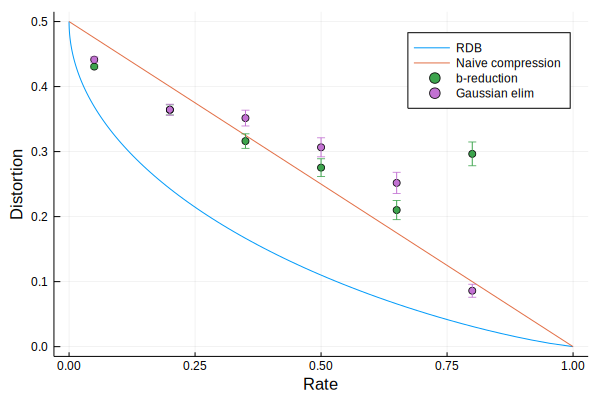

In [14]:
pl = plot(sims_b, label="b-reduction")
plot!(pl, sims_gauss, label="Gaussian elim")